#Importing Libraries

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import random

#Loading CIFAR-100 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


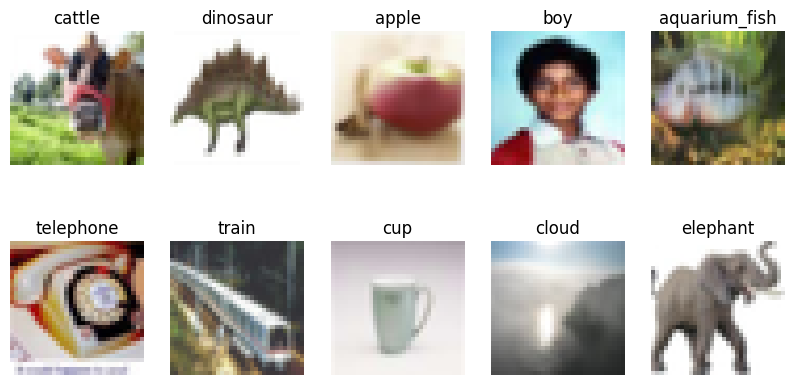

In [4]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
    'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Display some example images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')

plt.show()

In [5]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

###Adding augmentation

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(x_train)

In [7]:
# Convert class vectors to binary class matrices
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#Building Model Architecture

In [8]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def modifyNet(input_shape, num_classes=100, num_blocks_list=[2, 2, 2, 2], dropout_rate=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(128, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adding Dropout layer after the first set of residual blocks
    x = layers.Dropout(dropout_rate)(x)

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if i > 0 and j == 0 else 1
            x = resnet_block(x, 128 * 2**i, stride=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

In [9]:
input_shape = x_train.shape[1:]
model = modifyNet(input_shape, num_classes)


###Compiling the model

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


###Displaing model summary

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 128)          0         ['batch_normalization[0][0

#Training the model

In [12]:
epochs = 30
batch_size = 64
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs)

Epoch 1/30
782/782 [==============================] - 210s 235ms/step - loss: 4.0028 - accuracy: 0.0882
Epoch 2/30
782/782 [==============================] - 182s 233ms/step - loss: 3.3806 - accuracy: 0.1770
Epoch 3/30
782/782 [==============================] - 182s 233ms/step - loss: 2.9296 - accuracy: 0.2625
Epoch 4/30
782/782 [==============================] - 183s 234ms/step - loss: 2.5648 - accuracy: 0.3309
Epoch 5/30
782/782 [==============================] - 183s 233ms/step - loss: 2.2835 - accuracy: 0.3935
Epoch 6/30
782/782 [==============================] - 183s 234ms/step - loss: 2.0570 - accuracy: 0.4430
Epoch 7/30
782/782 [==============================] - 182s 233ms/step - loss: 1.8709 - accuracy: 0.4854
Epoch 8/30
782/782 [==============================] - 183s 233ms/step - loss: 1.7212 - accuracy: 0.5239
Epoch 9/30
782/782 [==============================] - 183s 233ms/step - loss: 1.5798 - accuracy: 0.5547
Epoch 10/30
782/782 [==============================] - 183s 234m

###Training for 20 more epoches

In [30]:
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=20)

Epoch 1/20
782/782 [==============================] - 183s 234ms/step - loss: 0.2709 - accuracy: 0.9123
Epoch 2/20
782/782 [==============================] - 183s 234ms/step - loss: 0.2576 - accuracy: 0.9155
Epoch 3/20
782/782 [==============================] - 183s 234ms/step - loss: 0.2506 - accuracy: 0.9186
Epoch 4/20
782/782 [==============================] - 183s 233ms/step - loss: 0.2301 - accuracy: 0.9245
Epoch 5/20
782/782 [==============================] - 182s 233ms/step - loss: 0.2141 - accuracy: 0.9290
Epoch 6/20
782/782 [==============================] - 183s 233ms/step - loss: 0.2093 - accuracy: 0.9319
Epoch 7/20
782/782 [==============================] - 183s 234ms/step - loss: 0.1979 - accuracy: 0.9357
Epoch 8/20
782/782 [==============================] - 183s 234ms/step - loss: 0.1922 - accuracy: 0.9374
Epoch 9/20
782/782 [==============================] - 183s 233ms/step - loss: 0.1865 - accuracy: 0.9396
Epoch 10/20
782/782 [==============================] - 182s 233m

#Visualizing learning curve of model

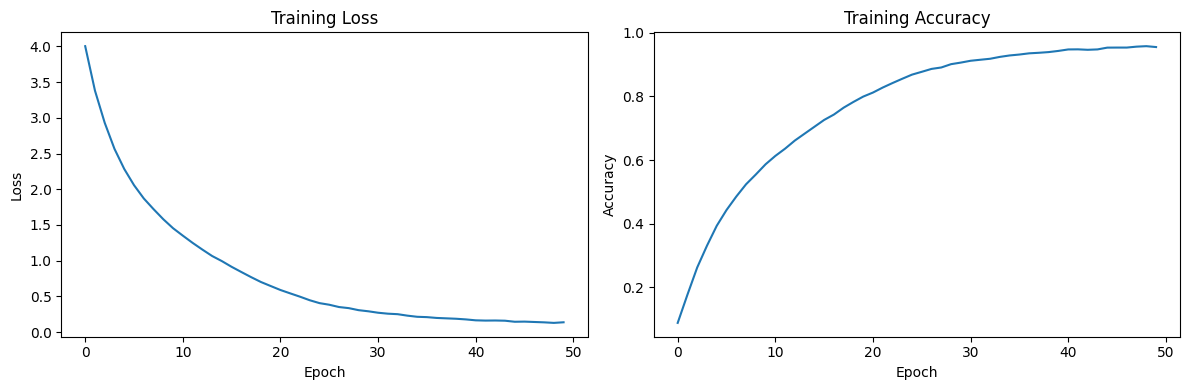

In [36]:
# Logs from additional training for 20 epochs
history2 = {
    'loss': [0.2709, 0.2576, 0.2506, 0.2301, 0.2141, 0.2093, 0.1979, 0.1922, 0.1865, 0.1773, 0.1645, 0.1609, 0.1621, 0.1592, 0.1445, 0.1465, 0.1413, 0.1363, 0.1287, 0.1372],
    'accuracy': [0.9123, 0.9155, 0.9186, 0.9245, 0.9290, 0.9319, 0.9357, 0.9374, 0.9396, 0.9433, 0.9479, 0.9482, 0.9468, 0.9480, 0.9536, 0.9538, 0.9538, 0.9567, 0.9582, 0.9554]
}

# Concatenate the history data
combined_history = {
    'loss': history.history['loss'] + history2['loss'],
    'accuracy': history.history['accuracy'] + history2['accuracy']
}

# Plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#Printing Test Accuracy

In [31]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')

313/313 - 11s - loss: 2.1489 - accuracy: 0.6489 - 11s/epoch - 34ms/step
Test Accuracy: 64.89%


#Saving the model

In [37]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
model.save('/content/gdrive/My Drive/CIFAR_100_NN_Model.h5')
model_json = model.to_json()
with open('my_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights('my_model_weights.h5')

In [39]:
!ls '/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'

'/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'


#Making Predictions


In [32]:
predictions = model.predict(x_test)

313/313 [==============================] - 10s 33ms/step


### Display the first few test images along with their predicted and actual classes

1/1 [==============================] - 0s 29ms/step


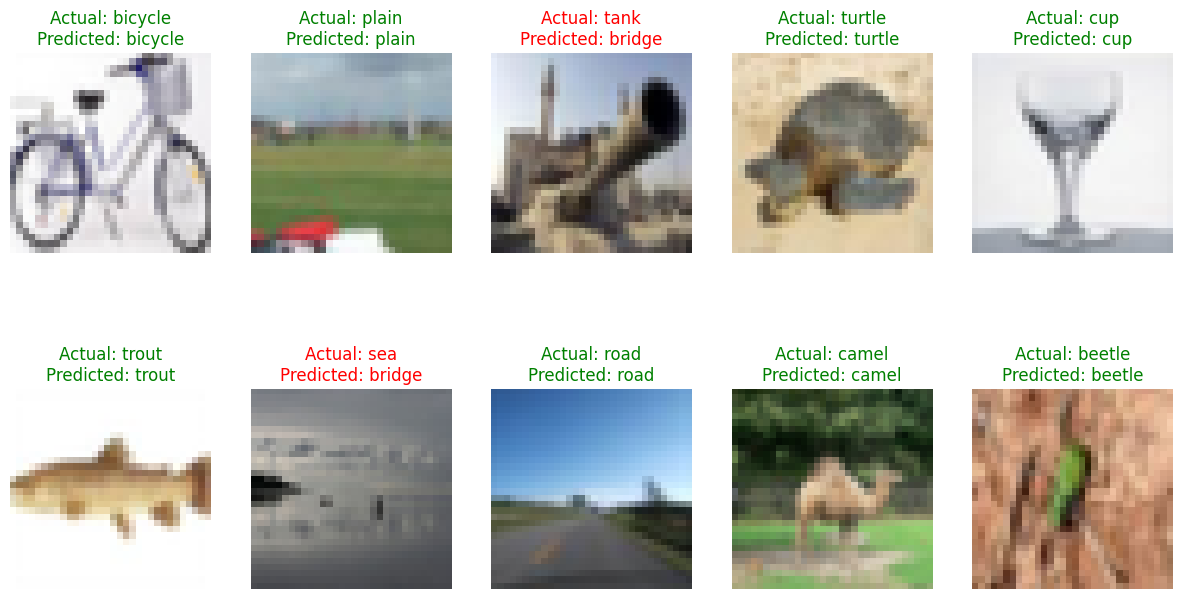

In [35]:
# Choose 10 random indices
random_indices = random.sample(range(len(x_test)), 10)

# Make predictions on the selected random test data
selected_x_test = x_test[random_indices]
selected_y_test = y_test[random_indices]
selected_predictions = model.predict(selected_x_test)

# Display the randomly selected test images along with their predicted and actual classes
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx])

    actual_class = int(np.argmax(selected_y_test[i]))  # Assuming y_test is one-hot encoded
    predicted_class = int(np.argmax(selected_predictions[i]))

    # Check if the prediction is correct
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.title(f'Actual: {class_names[actual_class]}\nPredicted: {class_names[predicted_class]}', color=text_color)
    plt.axis('off')

plt.show()